### MTH9855 Homework 2

#### ShengQuan Zhou

----------------------------------

### Problem 1

The data set accompanying this homework gives daily returns
for three stocks: TSLA, AAPL, and IBM.

**(a)**  Calculate the historical (regressed, no intercept) beta, for each of these assets as of Dec 31, 2014. In each case, calculate the appropriate t-statistic on the coefficient to test the null hypothesis β = 0 and state whether you reject the null hypothesis.

In [107]:
import pandas as pd
import datetime
from statsmodels import regression, stats
import statsmodels
import statsmodels.formula.api as smf

In [108]:
df = pd.read_csv('BetaExample.txt', '|')

In [122]:
betaList = []
regression_formula = 'R ~ RM-1'
for ticker in tickerList:
    subdf = df[(df['TICKER']==ticker) & (df['DATE']<'2015-01-01')].dropna()
    regression = smf.ols(regression_formula, data=subdf).fit()
    print(ticker)
    print(regression.summary())
    betaList.append(regression.params[0])

IBM
                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     3133.
Date:                Sat, 14 Oct 2017   Prob (F-statistic):               0.00
Time:                        10:13:53   Log-Likelihood:                 17657.
No. Observations:                6301   AIC:                        -3.531e+04
Df Residuals:                    6300   BIC:                        -3.531e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             0.9067      0.016     55.970     

**(b)** Compute the holdings vector $h\in \mathbb{R}^3$ for the unique portfolio which is dollar-neutral (ie. self-financing) and which has unit exposure to
AAPL and zero exposure to beta as of Dec 31, 2014.

#### Solution:

Construct a $3\times 3$ exposure matrix $X$: 
- The first column represents a constant exposure, the second column represents the exposure to APPL, and the third column represents the exposure to beta.
- The first row represents the exposures of IBM, the second row represents the exposures of AAPL, the third row represents the exposures of TSLA.
In other words,
$$
X = \begin{pmatrix}
1 & 0 & \beta_{\text{IBM}}\\
1 & 1 & \beta_{\text{AAPL}}\\
1 & 0 & \beta_{\text{TSLA}}\\
\end{pmatrix}.
$$
According to Lecture 3, Definition 3.2, for a portfolio with holdings vector $h\in \mathbb{R}^n$, the vector $X'h\in \mathbb{R}^p$ is called the exposure vector of the portfolio. We require
$$
X'h = \begin{pmatrix}
0 \\
1 \\
0 \\
\end{pmatrix}.
$$
Solve the above linear equation, we get the required portfolio holdings.

In [126]:
import numpy as np

In [142]:
numTickers = len(tickerList)
X = np.zeros((numTickers,numTickers))
X[:,0] = np.ones(numTickers)
X[:,2] = np.array(betaList)
for index, ticker in enumerate(tickerList):
    if ticker == 'AAPL':
        X[1,index] = 1

In [144]:
rhs = np.zeros(numTickers)
for index, ticker in enumerate(tickerList):
    if ticker == 'AAPL':
        rhs[index] = 1

In [153]:
h = np.linalg.solve(X.T, rhs)
results = pd.DataFrame()
results['Ticker'] = tickerList
results['Holdings'] = h
results

Ticker  Holdings
0    IBM -0.430856
1   AAPL  1.000000
2   TSLA -0.569144

**(c)** Compute the daily returns of the portfolio from (b) over the period
Jan 1, 2015 to Dec 31, 2015. Assume that each day, the portfolio
is rebalanced back to the initial holdings vector $h\in\mathbb{R}^3$ . Plot the
cumulative sum of the log returns.

#### Solution:

The portfolio return $R = r\cdot h'$, where $r$ is the vector of asset returns.

In [216]:
for index, ticker in enumerate(tickerList):
    subdf = df[(df['TICKER']==ticker) & (df['DATE']>'2014-12-31')].dropna()[['DATE','R']]
    if index == 0:
        mergeddf = subdf
    else:
        mergeddf = pd.merge(mergeddf, subdf, on='DATE')
    
r = mergeddf.drop('DATE',axis=1).values
portReturn = np.dot(r,h)
cumPortReturn = np.cumsum(np.log(1+pnl))

In [232]:
import matplotlib.pyplot as plt

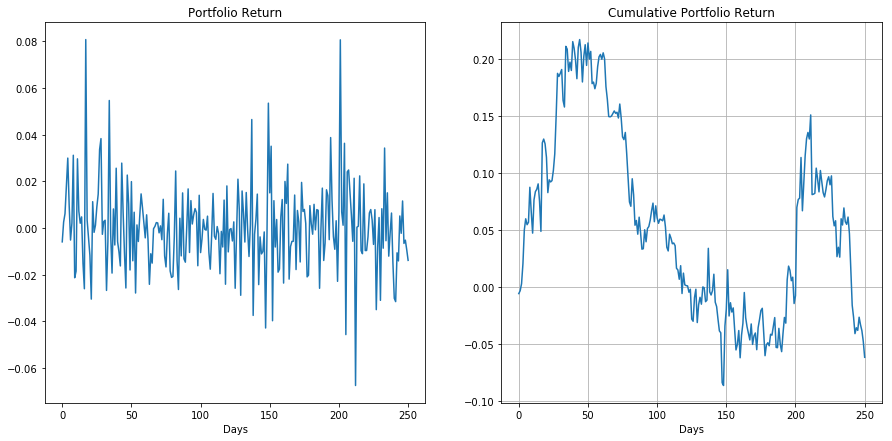

In [239]:
plt.rcParams["figure.figsize"] = [15,7]
f, axarr = plt.subplots(1, 2)
axarr[0].plot(portReturn)
axarr[0].set_title('Portfolio Return')
axarr[0].set_xlabel('Days')
axarr[1].plot(cumPortReturn)
axarr[1].set_title('Cumulative Portfolio Return')
axarr[1].set_xlabel('Days')
plt.grid(True)
plt.show()

**(d)** Compute the realized correlation of the returns in part (c) to the
market’s return. Construct a statistical test of the null hypothesis
that the correlation is zero. Is the realized correlation significantly
different from zero at the 95% level?

In [240]:
from scipy import stats

In [249]:
recentRM = df[(df['TICKER']=='AAPL') & (df['DATE']>'2014-12-31')].dropna()['RM']
ret = stats.pearsonr(portReturn, recentRM)
print("Pearson Correlation Coefficient =", ret[0], "with p-value:", ret[1])

Pearson Correlation Coefficient = 0.0291953228431 with p-value: 0.645279182566


**Comment**: A large $p$-value means that we fail to reject the null hypothesis that the correlation coefficient is zero.

### Problem 2

Use the Sherman-Morrison-Woodbury matrix inversion lemma
to derive a simple expression for the inverse of the covariance matrix in an
APT model. In other words, derive an expression for $\Sigma^{-1}$ where
$$
\Sigma = \mathbb{V}[R] = XF X' + D
$$
where $D$ is diagonal and $X$ is $n\times p$ and as usual we assume $p \ll n$. In your
answer, any matrices being inverted should be either diagonal or $p \times p$.

#### Proof:

The Sherman-Morrison-Woodbury matrix inversion lemma states that, suppose $A\in \mathbb{R}^{n\times n}$ is an invertible square matrix and $u,v\in \mathbb{R}^n$ are column vectors. Then $A+uv'$ is invertible if and only if $1+v'A^{-1}u\neq 0$. If $A+uv'$ is invertible, then its inverse is given by
$$
(A+uv')^{-1} = A^{-1} - \frac{A^{-1}uv'A^{-1}}{1+v'A^{-1}u}.
$$
A generalization, suppose instead $U$ and $V$ are $n\times m$ matrices, $C$ is an $m\times m$ matrix. Then $A+UCV'$ is invertible if $C^{-1}+V' A^{-1} U$ is invertible. If $A+UCV'$ is invertible, then its inverse is given by
$$
(A+UCV')^{-1} = A^{-1} - A^{-1}U(C^{-1}+V' A^{-1} U)^{-1}V' A^{-1}.
$$
Let $A=D$, $U=V=X$, we get
$$
\Sigma^{-1} = (XF X' + D)^{-1} = D^{-1} - D^{-1}X(F^{-1}+ X'D^{-1} X)^{-1}X' D^{-1}.
$$

### Problem 3

Show that, for any $n\times p$ real matrix $X$ (not necessarily full
rank) and $n$-vector $Y$ , the following are equal:

(1) $\lim_{\delta\rightarrow 0^+}(X'X+\delta \mathbb{1})^{-1}X'Y$;

(2) The smallest-norm element of $\text{argmin}_b \|Y-Xb\|$;

(3) $X^+Y = VS^+U'Y$ where $X=USV'$ is the SVD of X.

#### Proof:

We do it by (3)$\rightarrow$(1) and (3)$\rightarrow$(2).

**(3)$\rightarrow$(1)** 
Write 
$$
S = \text{diag}(\sigma_1, \cdots,\sigma_r,0,\cdots,0),
$$
where $r=\text{rank}(X)$.

\begin{eqnarray}
(X'X+\delta \mathbb{1})^{-1} &=& (VSU'USV'+\delta \mathbb{1})^{-1} \\
&=& (VS^2V'+\delta \mathbb{1})^{-1}\\
&=& V(S^2+\delta \mathbb{1})^{-1}V'\\
&=& V\text{diag}\left(\frac{1}{\sigma_1^2+\delta}, \cdots,\frac{1}{\sigma_r^2+\delta},0,\cdots,0\right)V'\\
\end{eqnarray}
Thus,
\begin{eqnarray}
(X'X+\delta \mathbb{1})^{-1}X'Y &=&  V\text{diag}\left(\frac{1}{\sigma_1^2+\delta}, \cdots,\frac{1}{\sigma_r^2+\delta},0,\cdots,0\right)V'VSU'Y\\
&=&  V\text{diag}\left(\frac{\sigma_1}{\sigma_1^2+\delta}, \cdots,\frac{\sigma_r}{\sigma_r^2+\delta},0,\cdots,0\right)U'Y.
\end{eqnarray}
The the limit
$$
\lim_{\delta\rightarrow 0^+}(X'X+\delta \mathbb{1})^{-1}X'Y = V\text{diag}\left(\frac{1}{\sigma_1}, \cdots,\frac{1}{\sigma_r},0,\cdots,0\right)U'Y = VS^+U'Y = X^+Y.
$$

**(3)$\rightarrow$(2)** 

$b= X^+Y = VS^+U'Y$ is a solution to $\text{argmin}_b \|Y-Xb\|$ because
$$
X'Xb  = X'XVS^+U'Y = VSU' USV'VS^+U'Y = VS^2S^+U'Y = VSU'Y = X'Y\Rightarrow X'(Y-Xb) = 0.
$$
In addition, for any solution $b$ satisfying $Xb=Y$:
\begin{eqnarray}
\|b\|^2 &=& \|b - X^+Y + X^+Y\|^2 \\
&=& \|b- X^+Y\|^2 + \| X^+Y\|^2 + 2 (b - X^+Y)'X^+Y,
\end{eqnarray}
where 
\begin{eqnarray}
 (b - X^+Y)'X^+Y &=& (b - X^+Y)'VS^+U'Y \\
  &=& (b - X^+Y)' VS^2 V'V (S^+)^3 U'Y \\
  &=& (b - X^+Y)' X'X V (S^+)^3 U'Y \\
  &=& (X'Xb - X'XX^+Y)'X V (S^+)^3 U'Y \\
&=& (X'Xb - VS^2 V'VS^+U'Y)'V (S^+)^3 U'Y \\
&=& (X'Xb - VSU'Y)'V (S^+)^3 U'Y \\
&=& (X'Xb - X'Y)'V (S^+)^3 U'Y \\
&=& (Xb - Y)'X V (S^+)^3 U'Y \\
&=& 0.
\end{eqnarray}
Thus,
$$
\|b\|^2 = \|b- X^+Y\|^2 + \| X^+Y\|^2 \ge \| X^+Y\|^2.
$$
In other words, $X^+Y$ is the smallest-norm element of $\text{argmin}_b \|Y-Xb\|$.